In [1]:
from sklearn.model_selection import train_test_split
import concurrent.futures
import cv2
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.decomposition import PCA

np.random.seed(42)


In [3]:
#Definations

def load_and_normalize_image(image_path, target_size=(512, 512)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None or img.size == 0:
        print(f"Warning: Could not read image {image_path}")
        return None

    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    normalized_img = img_resized / 255.0
    return normalized_img

def load_and_normalize_images_parallel(dataframe, image_folder, batch_size=1000, n_workers=8, target_size=(512, 512)):
    normalized_images = []
    num_batches = len(dataframe) // batch_size + \
        (1 if len(dataframe) % batch_size != 0 else 0)

    image_paths = [f"{image_folder}/{row['Image Index']}" for _, row in dataframe.iterrows()]

    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = min((i + 1) * batch_size, len(dataframe))
        batch_image_paths = image_paths[batch_start:batch_end]

        with concurrent.futures.ThreadPoolExecutor(max_workers=n_workers) as executor:
            normalized_batch_images = list(executor.map(
            lambda img_path: load_and_normalize_image(img_path, target_size=target_size), batch_image_paths))

        normalized_batch_images = [img for img in normalized_batch_images if img is not None]
        normalized_images.append(normalized_batch_images)

    return np.concatenate(normalized_images, axis=0)


def create_disease_dataset(disease, data):
    disease_data = data[data['Finding Labels'] == disease]
    no_finding_data = data[data['Finding Labels'] == 'No Finding']
    combined_data = pd.concat([disease_data, no_finding_data])
    combined_data['Label'] = combined_data['Finding Labels'].apply(lambda x: 1 if disease in x else 0)
    combined_data= combined_data.drop(columns=['Patient ID', 'Finding Labels', "Follow-up #",
                   'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]'])
    np.random.seed(42)
    combined_data = combined_data.sample(frac=1)
    return combined_data




In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('Data_Entry_2017_v2020.csv')

data1 = data.copy()

data1['Finding Labels'] = data1['Finding Labels'].str.split('|')

exploded_data = data1.explode('Finding Labels').copy()

labels = exploded_data['Finding Labels'].str.split(
    '|').explode().value_counts()

min_count_threshold = 10000

selected_diseases = labels[labels >= min_count_threshold].index

min_images = 5000

undersampled_data = pd.DataFrame(columns=exploded_data.columns)

for disease in selected_diseases:
    disease_data = exploded_data[exploded_data['Finding Labels'].str.contains(
        disease)]

    undersampled_disease_data = disease_data.sample(
        min_images, random_state=42)

    undersampled_data = pd.concat(
        [undersampled_data, undersampled_disease_data])

undersampled_data.reset_index(drop=True, inplace=True)

sampled_labels = undersampled_data['Finding Labels'].str.split(
    '|').explode().value_counts()

print('Loading and undersampling done')


numeric_features = ['Patient Age']
numeric_transformer = Pipeline(steps=[
    ('minmaxscaler', MinMaxScaler())
])

categorical_features = ['Patient Gender', 'View Position']
categorical_transformer = Pipeline(steps=[
    ('onehotencoder', OneHotEncoder(sparse_output=True))
])

preprocessor = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

infiltration_data = create_disease_dataset('Infiltration', undersampled_data)
effusion_data = create_disease_dataset('Effusion', undersampled_data)
atelectasis_data = create_disease_dataset('Atelectasis', undersampled_data)
infiltration_data.reset_index(drop=True, inplace=True)
effusion_data.reset_index(drop=True, inplace=True)
atelectasis_data.reset_index(drop=True, inplace=True)

print('Infiltration:', len(infiltration_data))
print('Effusion:', len(effusion_data))
print('Atelectasis:', len(atelectasis_data))


Loading and undersampling done
Infiltration: 10000
Effusion: 10000
Atelectasis: 10000


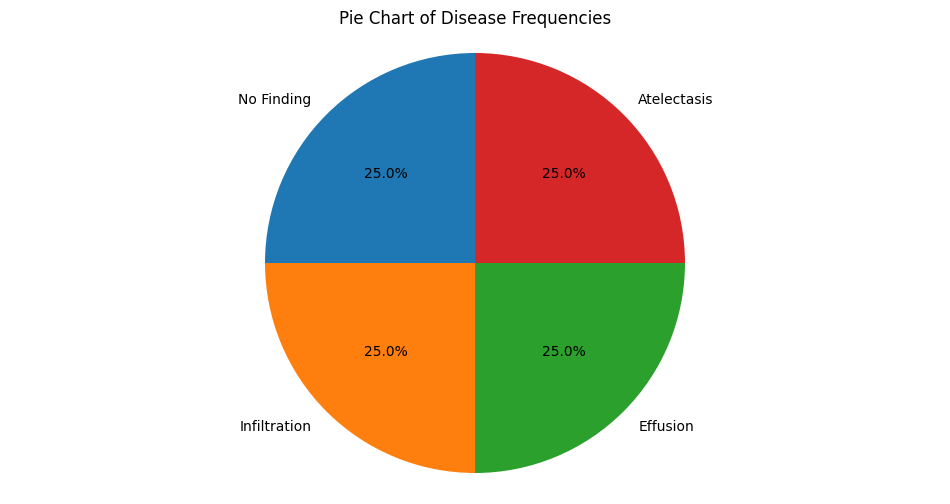

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.pie(sampled_labels.values, labels=sampled_labels.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.title('Pie Chart of Disease Frequencies')
plt.savefig('disease_pie_chart.png')
plt.show()


In [6]:
image_folder = 'C:/Users/Aditya/Desktop/Spring 23/CMSE 890 Applied Machine Learning/Project/images'
X_images_infiltration = load_and_normalize_images_parallel(infiltration_data, image_folder)
y_infiltration = infiltration_data['Label'].values
X_images_effusion = load_and_normalize_images_parallel(effusion_data, image_folder)
y_effusion = effusion_data['Label'].values
X_images_atelectasis = load_and_normalize_images_parallel(atelectasis_data, image_folder)
y_atelectasis = atelectasis_data['Label'].values


In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, recall_score
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import seaborn as sns
import pandas as pd


np.random.seed(42)


def fit_and_evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, cv=5):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    recall = recall_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cv_recall_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='recall')
    cv_precision_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='precision')
    mean_cv_recall = (cv_recall_scores)
    mean_cv_precision = (cv_precision_scores)
    return y_pred, recall, report, mean_cv_recall, mean_cv_precision

def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.savefig(f"{title}_confusion_matrix.png", dpi=300)
    plt.show()

def plot_pca_variance_explained(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Components vs Variance Explained')
    plt.savefig("pca.png", dpi=300)
    plt.show()

def perform_hyperparameter_tuning(pipeline, X_train, y_train, param_grid):
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='recall', verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")
    return grid_search.best_params_


def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='recall', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label='Training Recall')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation Recall')
    plt.xlabel('Training Set Size')
    plt.ylabel('Recall')
    plt.title(title)
    plt.legend()
    plt.savefig(f"{title}_learning_curve.png", dpi=300)
    plt.show()

def plot_classification_report(classification_report, title):
    df_classification_report = pd.DataFrame(classification_report).transpose().drop(['support'], axis=1)
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_classification_report, annot=True, cmap="YlGnBu", vmin=0, vmax=1, cbar=False, fmt='.2f')
    plt.title(title)
    plt.savefig(f"{title}_classification_report.png", dpi=300)
    plt.show()



Processing Infiltration


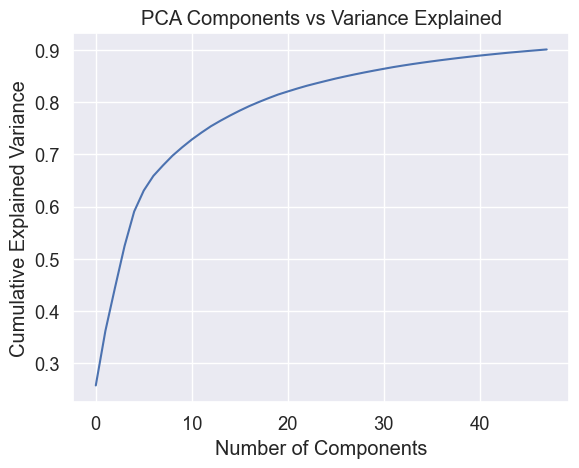

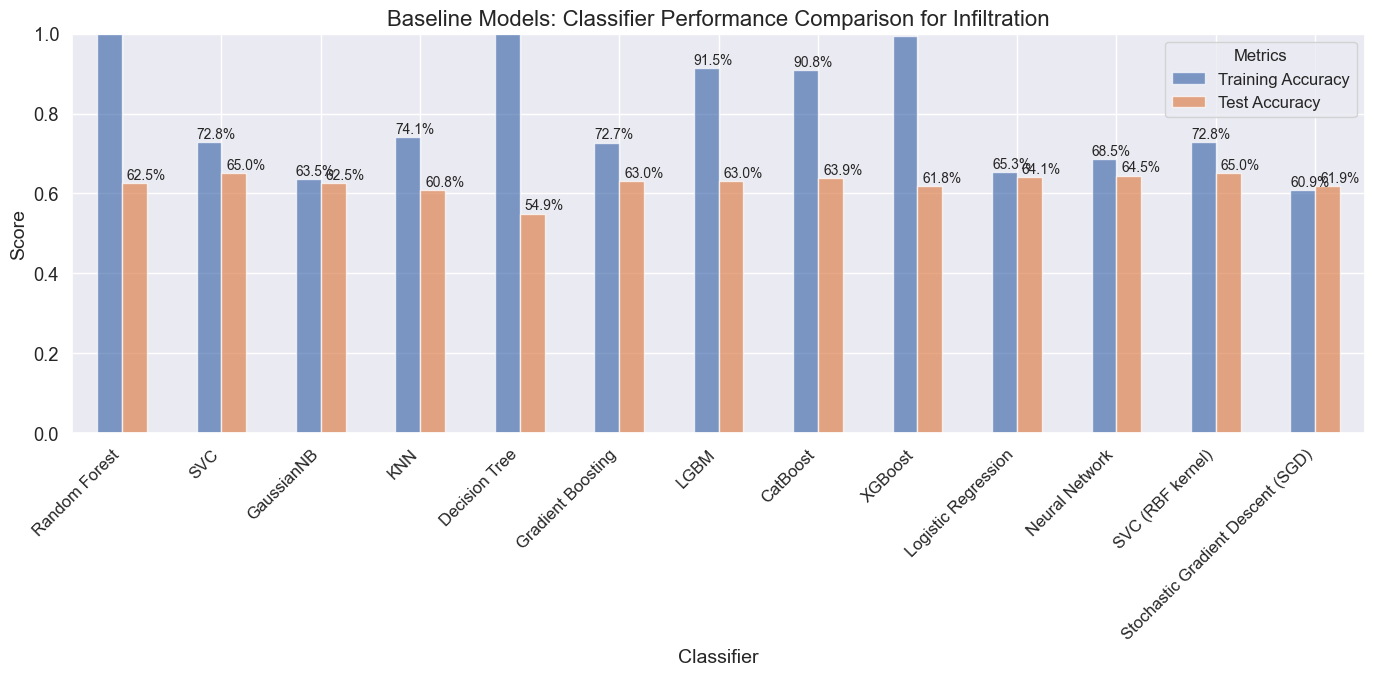

Processing Effusion


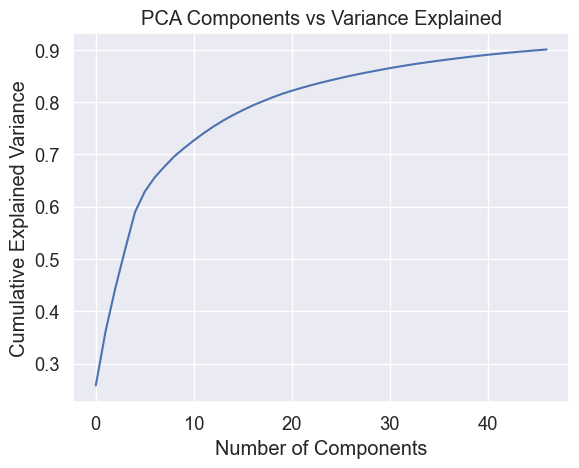

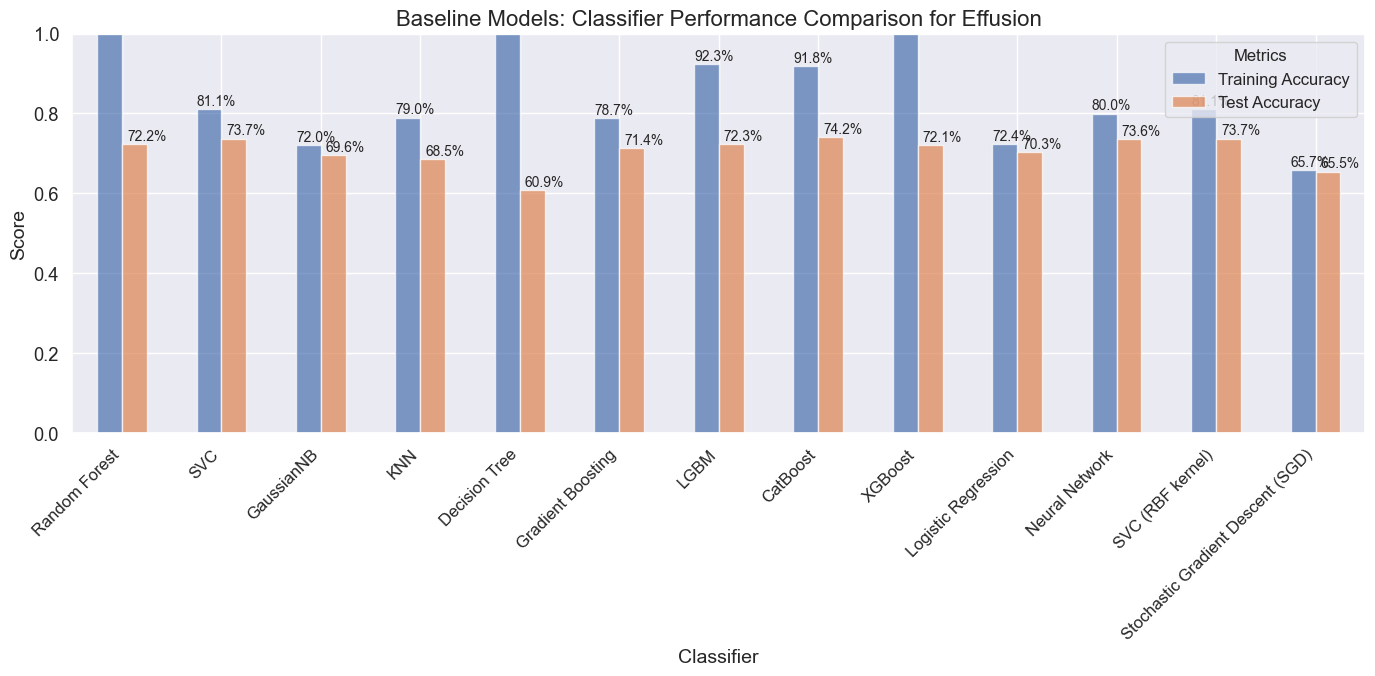

Processing Atelectasis


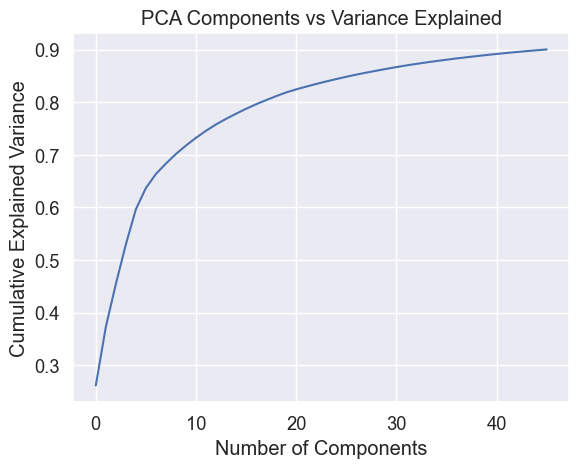

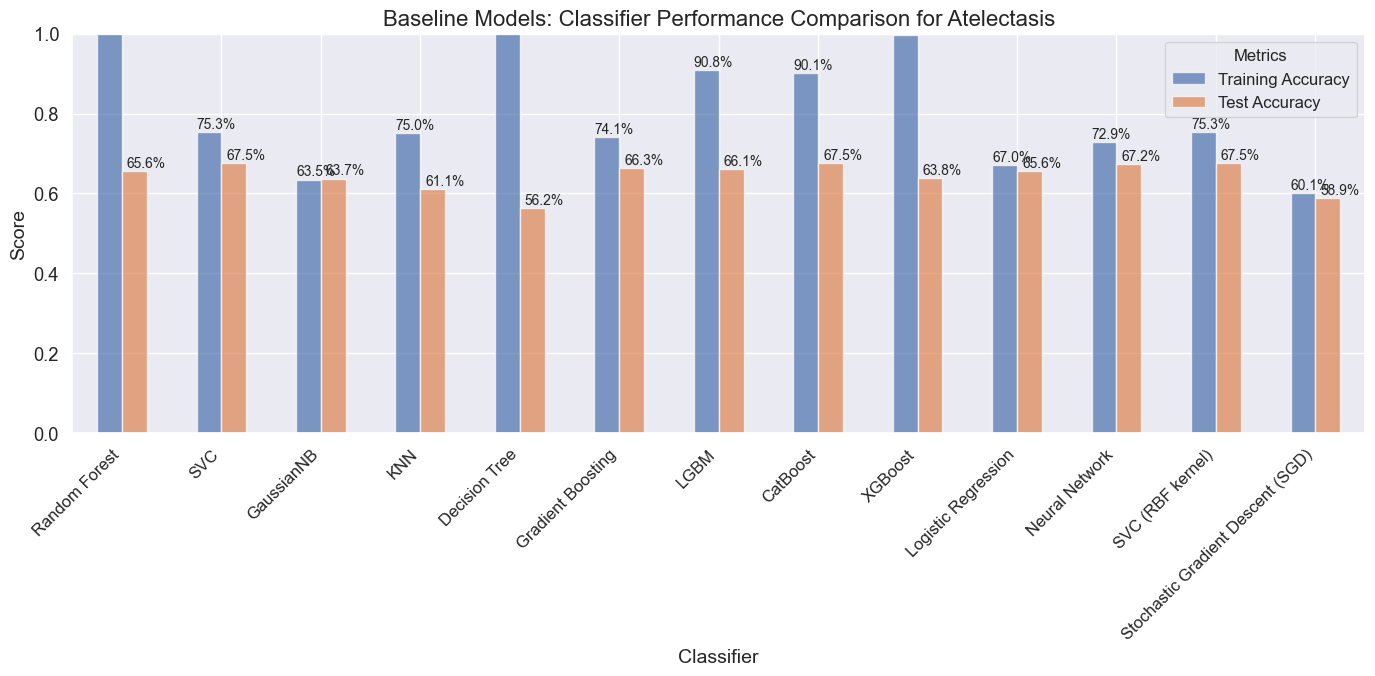

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.2)

classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(random_state=42, probability=True),
    'GaussianNB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000, early_stopping=True),
    'SVC (RBF kernel)': SVC(kernel='rbf', random_state=42, probability=True),
    'Stochastic Gradient Descent (SGD)': SGDClassifier(random_state=42, max_iter=1000),
}


diseases = {
    'Infiltration': {
        'X_images': X_images_infiltration,
        'y': y_infiltration,
        'data': infiltration_data
        
    },
    'Effusion': {
        'X_images': X_images_effusion,
        'y': y_effusion,
        'data': effusion_data

    },
    'Atelectasis': {
        'X_images': X_images_atelectasis,
        'y': y_atelectasis,
        'data': atelectasis_data
    }
}


results = {}

for disease, data in diseases.items():
    X_images = data['X_images']
    y = data['y']
    pdata = data['data']
    print(f"Processing {disease}")
    X_images_flat = [img.flatten() for img in X_images]
    X_images_flat = np.array(X_images_flat)
    X_patient = preprocessor.fit_transform(pdata.drop(columns=['Image Index', 'Label']))

    X_combined = np.hstack((X_images_flat, X_patient))

    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

    # PCA
    pca = PCA(n_components=0.9)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    plot_pca_variance_explained(pca)

    results[disease] = {
        'accuracies': [],
        'precision_recall': {},
        'roc': {}   
    }

    for name, classifier in classifiers.items():
        pipeline = Pipeline(steps=[('classifier', classifier)])

        pipeline.fit(X_train_pca, y_train)

        y_train_pred = pipeline.predict(X_train_pca)
        training_accuracy = accuracy_score(y_train, y_train_pred)

        y_test_pred = pipeline.predict(X_test_pca)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        results[disease]['accuracies'].append((name, training_accuracy, test_accuracy))

    summary_table = pd.DataFrame(results[disease]['accuracies'], columns=['Classifier', 'Training Accuracy', 'Test Accuracy'])

    fig, ax = plt.subplots(figsize=(14, 7))
    
    
    summary_table.plot(x='Classifier', y=['Training Accuracy', 'Test Accuracy'], kind='bar', alpha=0.7, ax=ax)
    ax.set_xticks(range(len(summary_table['Classifier'])))
    ax.set_xticklabels(summary_table['Classifier'], rotation=45, ha='right', fontsize=12)

    for i, row in summary_table.iterrows():
        ax.annotate(f"{row['Training Accuracy'] * 100:.1f}%", (i - 0.25, row['Training Accuracy'] + 0.01), fontsize=10)
        ax.annotate(f"{row['Test Accuracy'] * 100:.1f}%", (i + 0.05, row['Test Accuracy'] + 0.01), fontsize=10)

    ax.set_ylim(0, 1)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_xlabel('Classifier', fontsize=14)
    ax.set_title(f'Baseline Models: Classifier Performance Comparison for {disease}', fontsize=16)
    ax.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right', title='Metrics', fontsize=12, title_fontsize=12)

    plt.tight_layout()
    
    plt.savefig(f"{disease}_classifier_comparison.png", dpi=300)
    
    plt.show()

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import validation_curve

models = [
    ('SVC', SVC(random_state=42))

]

diseases = {
    'Infiltration': {
        'X_images': X_images_infiltration,
        'y': y_infiltration,
        'data': infiltration_data
        
    },
    'Effusion': {
        'X_images': X_images_effusion,
        'y': y_effusion,
        'data': effusion_data

    },
    'Atelectasis': {
        'X_images': X_images_atelectasis,
        'y': y_atelectasis,
        'data': atelectasis_data
    }
}

results1 = {}

precision_recall_results = {}

mean_cv_scores = {
    'recall': {disease: {} for disease in diseases},
    'precision': {disease: {} for disease in diseases}
}

Processing Infiltration


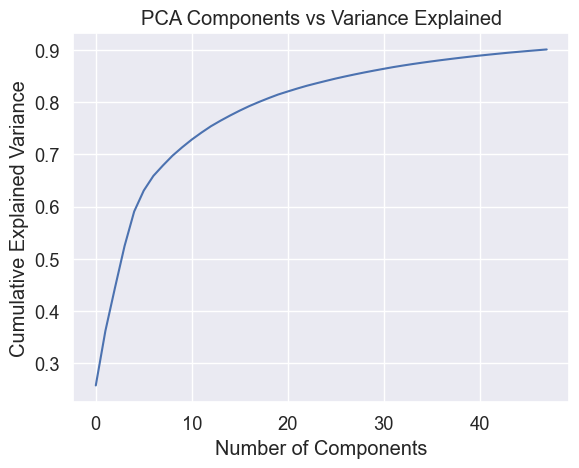

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'classifier__C': 3, 'classifier__decision_function_shape': 'ovo', 'classifier__degree': 2, 'classifier__probability': True, 'classifier__tol': 0.001}
Best score: 0.6187542255890668
Best parameters for SVC: {'classifier__C': 3, 'classifier__decision_function_shape': 'ovo', 'classifier__degree': 2, 'classifier__probability': True, 'classifier__tol': 0.001}


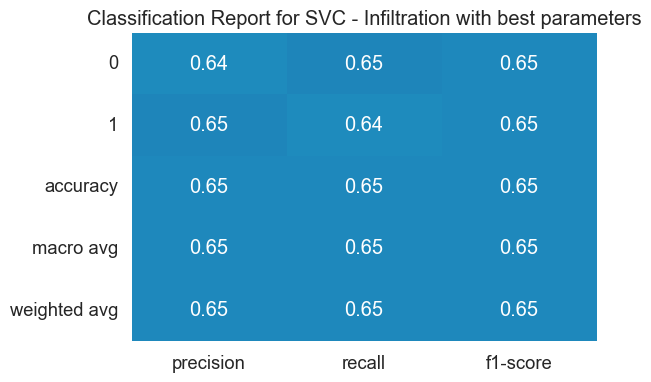

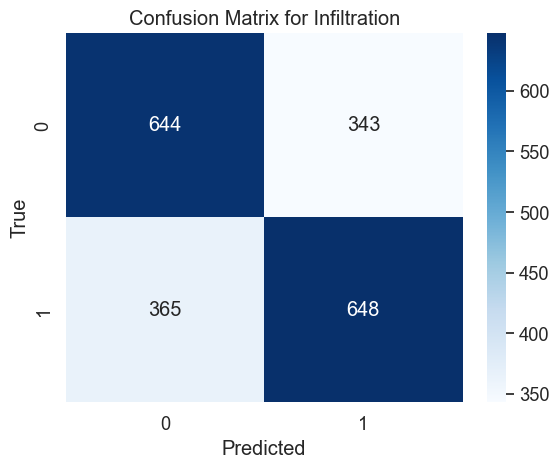

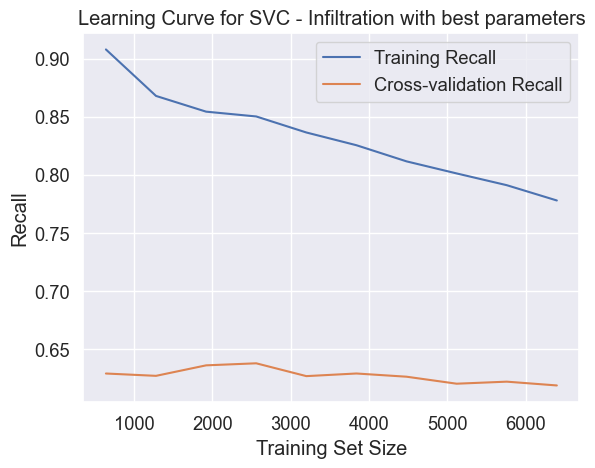

Processing Effusion


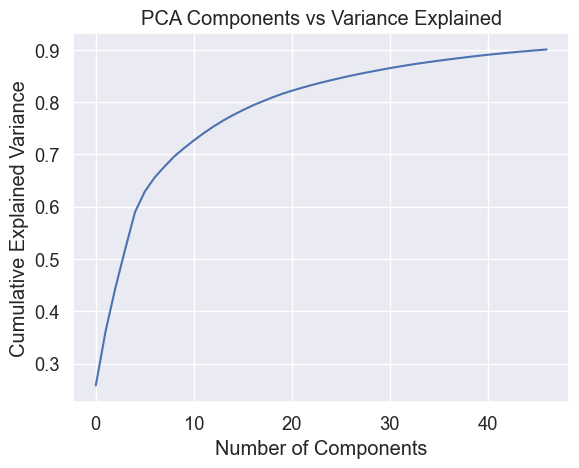

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'classifier__C': 1, 'classifier__decision_function_shape': 'ovo', 'classifier__degree': 2, 'classifier__probability': True, 'classifier__tol': 0.001}
Best score: 0.7509378842337966
Best parameters for SVC: {'classifier__C': 1, 'classifier__decision_function_shape': 'ovo', 'classifier__degree': 2, 'classifier__probability': True, 'classifier__tol': 0.001}


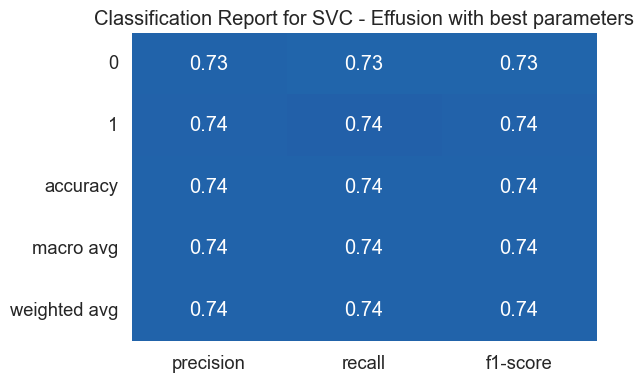

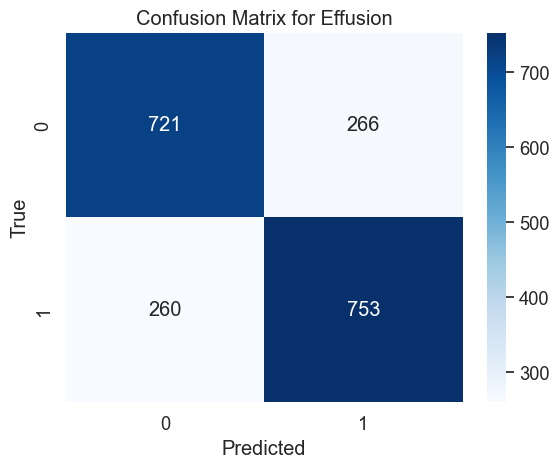

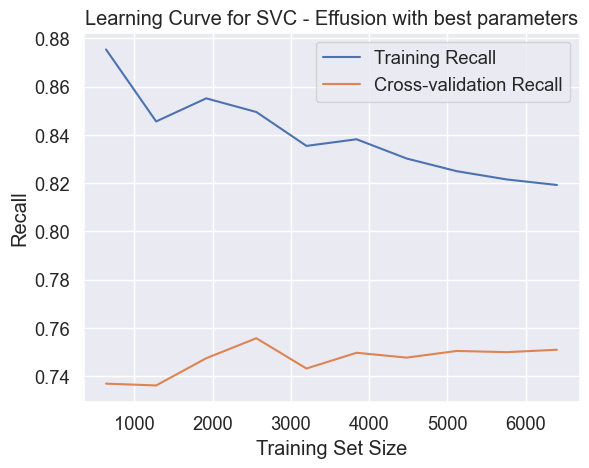

Processing Atelectasis


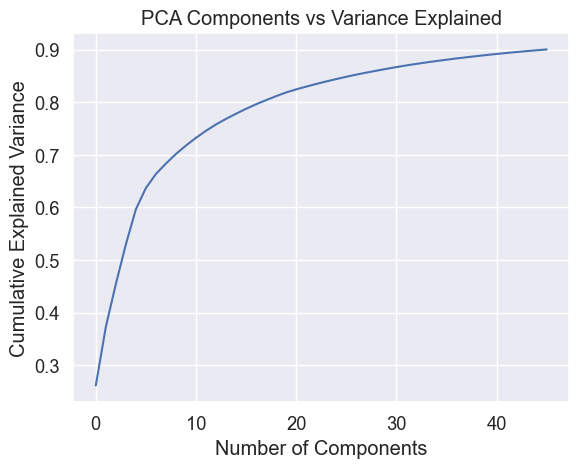

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'classifier__C': 3, 'classifier__decision_function_shape': 'ovo', 'classifier__degree': 2, 'classifier__probability': True, 'classifier__tol': 0.001}
Best score: 0.6980204589264881
Best parameters for SVC: {'classifier__C': 3, 'classifier__decision_function_shape': 'ovo', 'classifier__degree': 2, 'classifier__probability': True, 'classifier__tol': 0.001}


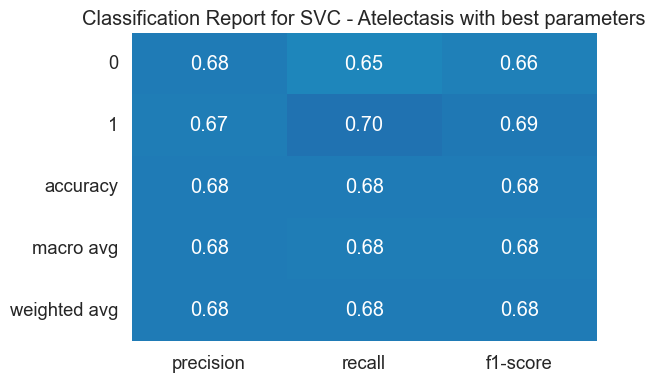

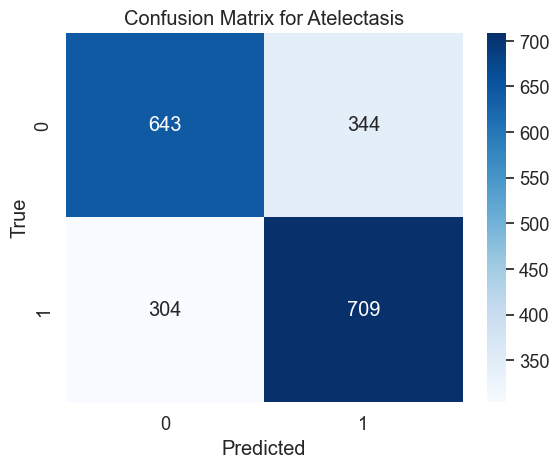

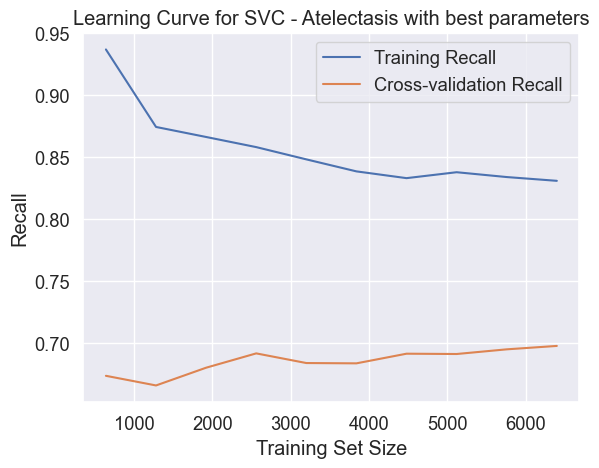

In [10]:
for disease, data in diseases.items():
    X_images = data['X_images']
    y = data['y']
    pdata = data['data']

    print(f"Processing {disease}")
    data = create_disease_dataset(disease, undersampled_data)
    data.reset_index(drop=True, inplace=True)

    X_patient = preprocessor.fit_transform(pdata.drop(columns=['Image Index', 'Label']))

    X_images_flat = [img.flatten() for img in X_images]
    X_images_flat = np.array(X_images_flat)

    X_combined = np.hstack((X_images_flat, X_patient))

    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

    # PCA
    pca = PCA(n_components=0.9)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    plot_pca_variance_explained(pca)

    results1[disease] = {
        'precision_recall': {},
        'roc': {}
    }

    for name, model in models:

        results1[disease][name] = {}


        model_pipeline = Pipeline([
            ('classifier', model)
        ])

        if name == 'SVC':
            param_grid = {
                'classifier__C': [0.1, 1, 3],
                'classifier__degree': [2, 3, 4],
                'classifier__probability': [True],
                'classifier__tol': [1e-3, 1e-5],
                'classifier__decision_function_shape': ['ovo', 'ovr'],
            }
        
        best_params = perform_hyperparameter_tuning(model_pipeline, X_train_pca, y_train, param_grid)
        print(f"Best parameters for {name}: {best_params}")

        model_pipeline.set_params(**best_params)

        y_pred, recall, report,  mean_cv_recall, mean_cv_precision = fit_and_evaluate_pipeline(model_pipeline, X_train_pca, X_test_pca, y_train, y_test)
        plot_classification_report(report, f'Classification Report for {name} - {disease} with best parameters')
        
        plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix for {disease}')
        y_scores = model_pipeline.predict_proba(X_test_pca)[:, 1]
        
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        results1[disease]['precision_recall'][name] = (recall, precision)

        fpr, tpr, _ = roc_curve(y_test, y_scores)
        results1[disease]['roc'][name] = (fpr, tpr)

        mean_cv_scores['recall'][disease][name] = mean_cv_recall
        mean_cv_scores['precision'][disease][name] = mean_cv_precision

        plot_learning_curve(model_pipeline, X_train_pca, y_train, f'Learning Curve for {name} - {disease} with best parameters')


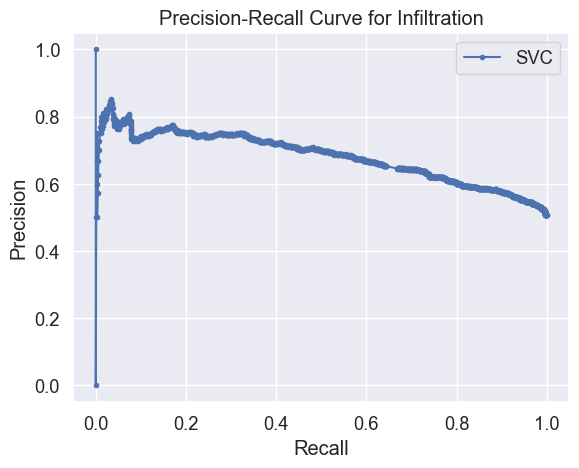

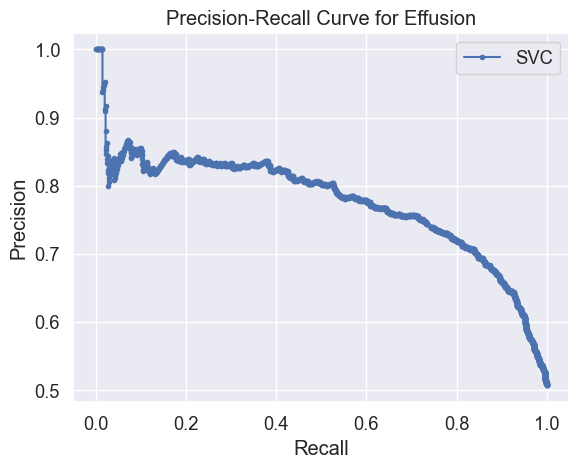

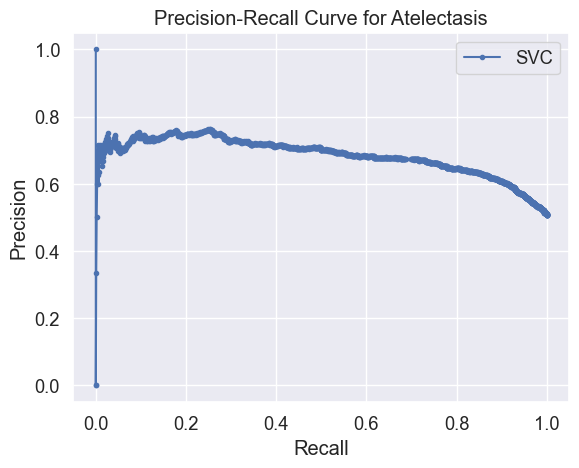

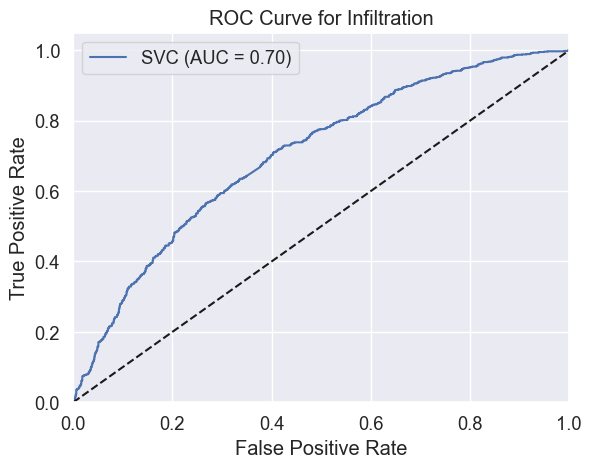

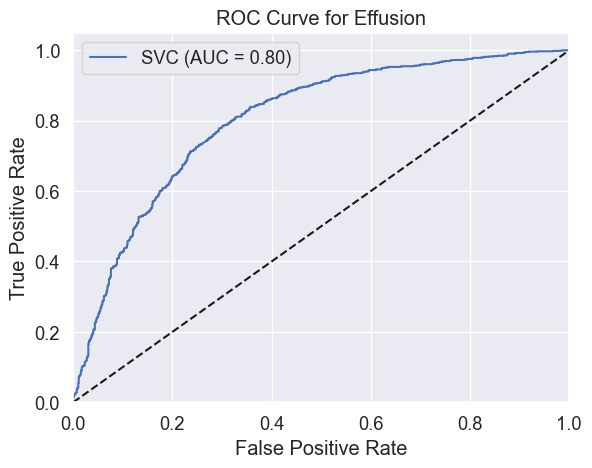

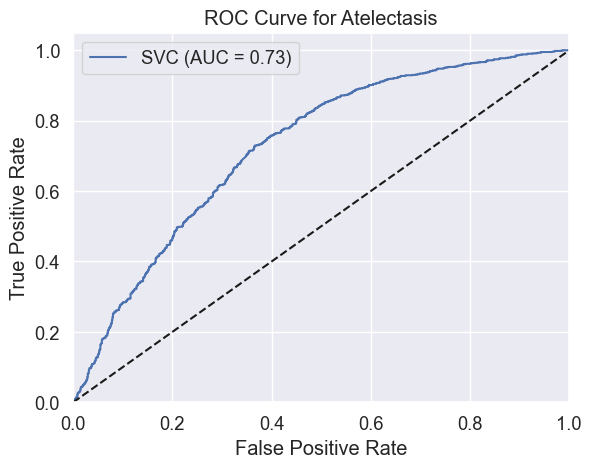

Completed


In [11]:
for disease in diseases.keys():
    plt.figure()
    for name, (recall, precision) in results1[disease]['precision_recall'].items():
        plt.plot(recall, precision, marker='.', label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(f'Precision-Recall Curve for {disease}')
    plt.savefig(f'Precision-Recall Curve for {disease}.png', dpi=300)
    plt.show()

for disease in diseases.keys():
    plt.figure()
    for name, (fpr, tpr) in results1[disease]['roc'].items():
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title(f'ROC Curve for {disease}')
    plt.savefig(f'ROC Curve for {disease}.png', dpi=300)
    plt.show()

print("Completed")
